# EW Single Sim

DEBUG:timer.simulate:start
DEBUG:timer.simulate:cost 6 ms


                Long     Lat  population  births
London        -0.105  51.517   2462500.0   44851
Birmingham    -1.860  52.485    993310.0   22644
Liverpool     -2.942  53.417    666230.0   15623
Manchester    -2.250  53.482    614760.0   12332
Sheffield     -1.467  53.383    474180.0   10111
Leeds         -1.538  53.805    451100.0    8601
Bristol       -2.570  51.477    405530.0    7807
Newcastle     -1.602  54.973    262920.0    5422
Nottingham    -1.160  52.967    262310.0    5733
Bradford      -1.750  53.788    261890.0    4678
Leicester     -1.137  52.635    257450.0    5280
Stoke         -1.465  52.403    250500.0    5445
Hull          -0.340  53.750    229640.0    5031
Coventry      -1.508  52.403    222210.0    5584
Cardiff       -3.175  51.482    215130.0    4514
Croydon       -0.083  51.363    190130.0    3582
Harrow        -0.348  51.583    185090.0    3472
Sunderland    -1.385  54.910    161450.0    3656
Portsmouth    -1.072  50.808    155860.0    3755
Salford       -2.295

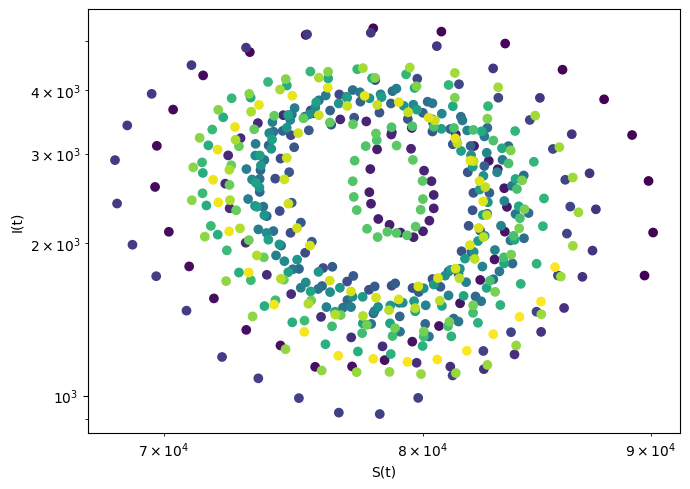

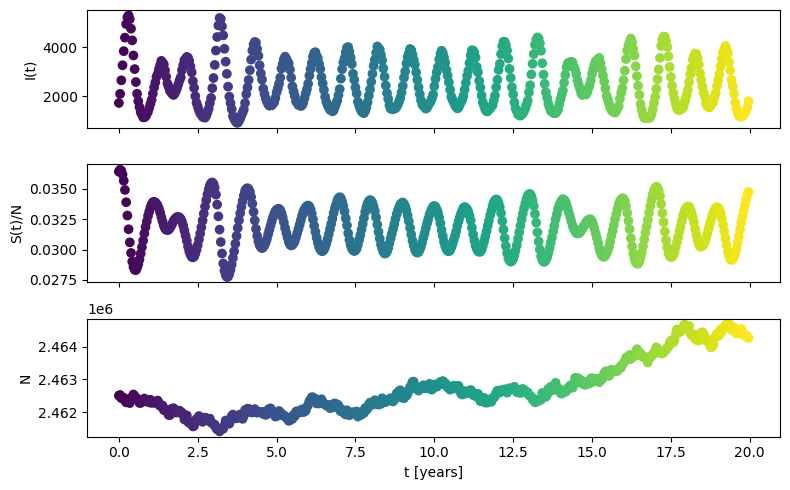

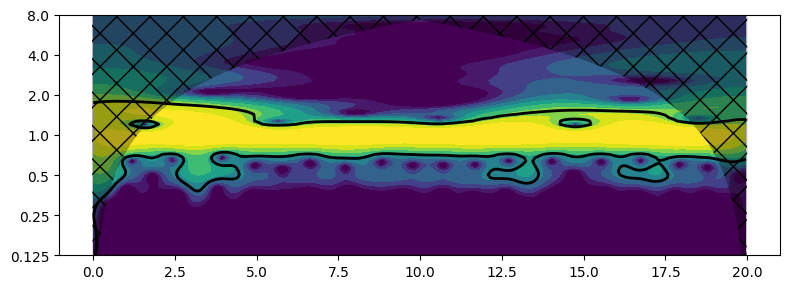

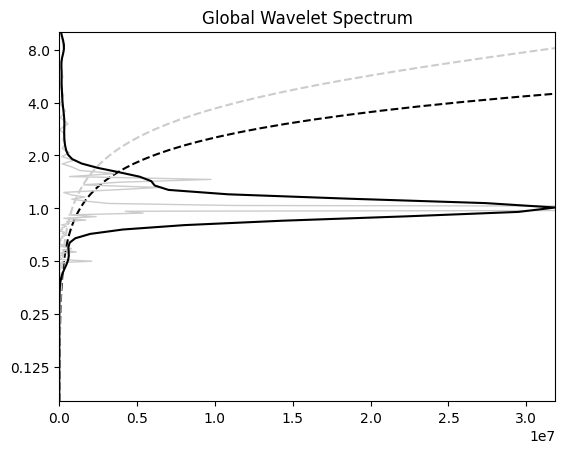

In [43]:
from timer import timer # https://github.com/LucienShui/timer

import logging
logging.basicConfig()
logging.getLogger("timer").setLevel(logging.DEBUG)

from settlements import parse_settlements
settlements_df = parse_settlements()
settlement = settlements_df.loc["London"]

biweek_steps = 26 * 20
from idmlaser.utils import PropertySet
params = PropertySet({"beta": 32, "seasonality": 0.06, "demog_scale": 1.5})
print(params)

import numpy as np

def init_state(settlement_s, params):

    population = settlement_s.population.astype(int)
    births = settlement_s.births.astype(int)

    N = population
    S = births * 2
    I = int(S / 26.0 / 2.0)

    state = np.array([S, I, N-S-I])

    params.biweek_avg_births = params.demog_scale * births / 26.0
    params.biweek_death_prob = params.demog_scale * births / N / 26.0

    return state

def step_state(state, params, t, keep_alive=False):

    expected = params.beta * (1 + params.seasonality * np.cos(2 * np.pi * t / 26.0)) * state[1]
    prob = 1 - np.exp(-expected/state.sum())
    dI = np.random.binomial(n=state[0], p=prob)

    state[2] += state[1]
    state[1] = 0

    births = np.random.poisson(params.biweek_avg_births)
    deaths = np.random.binomial(n=state, p=params.biweek_death_prob)

    state[0] += births
    state -= deaths

    if keep_alive:
        dI += 1

    state[1] += dI
    state[0] -= dI

    return

@timer("simulate", unit="ms")
def simulate(initial_state, params, n_steps, keep_alive=False):

    state_timeseries = np.zeros((n_steps, 3), dtype=int)

    state = initial_state

    for t in range(n_steps):
        state_timeseries[t, :] = state
        step_state(state, params, t, keep_alive)

    return state_timeseries

initial_state = init_state(settlement, params)
states = simulate(initial_state, params, n_steps=biweek_steps)

from plotting import plot_timeseries, plot_wavelet_spectrum
plot_timeseries(states)
plot_wavelet_spectrum(states[:, 1])

import matplotlib.pyplot as plt
plt.show()

# LASER Single Sim

In [38]:
import numpy as np
from timer import timer

from idmlaser.numpynumba import Population
from idmlaser.utils import PropertySet

import logging
logging.basicConfig()
logging.getLogger("timer").setLevel(logging.DEBUG)

class Model:
    pass

model = Model()
model.nodes = Population(1) # 1 node
model.nodes.add_vector_property("states", 3) # S, I, R

def init_state(model, settlement_s, params):

    population = settlement_s.population.astype(int)
    births = settlement_s.births.astype(int)

    N = population
    S = births * 2
    I = int(S / 26.0 / 2.0)

    model.nodes.states[0, :] = np.array([S, I, N-S-I])

    params.biweek_avg_births = params.demog_scale * births / 26.0
    params.biweek_death_prob = params.demog_scale * births / N / 26.0

    return

from settlements import parse_settlements
settlements_df = parse_settlements()
settlement = settlements_df.loc["London"]

model.params = PropertySet({"beta": 32, "seasonality": 0.06, "demog_scale": 1.5})

init_state(model, settlement, model.params)

model.params.biweek_steps = 26 * 20
model.nodes.add_vector_property("timeseries", (model.params.biweek_steps, 3))

def step(model, t):

    states = model.nodes.states[0, :]
    params = model.params

    model.nodes.timeseries[0, t, :] = states
    expected = params.beta * (1 + params.seasonality * np.cos(2 * np.pi * t / 26.0)) * states[1] # expected number of infections based on current value of I
    prob = 1 - np.exp(-expected/states.sum()) # probability of infection
    dI = np.random.binomial(n=states[0], p=prob) # number of new infections in S

    states[2] += states[1]  # move I to R
    states[1] = 0           # reset I

    births = np.random.poisson(params.biweek_avg_births) # number of births
    deaths = np.random.binomial(n=states, p=params.biweek_death_prob).astype(states.dtype) # number of deaths

    states[0] += births # add births to S
    states -= deaths # remove deaths from each compartment

    states[1] += dI # add new infections to I
    states[0] -= dI # remove new infections from S

    return

@timer("simulate", unit="ms")
def simulate(model, steps):
    for t in range(model.params.biweek_steps):
        for phase in model.phases:
            phase(model, t)

    return

model.phases = [step]

simulate(model, model.params.biweek_steps)


DEBUG:timer.simulate:start
DEBUG:timer.simulate:cost 8 ms


                Long     Lat  population  births
London        -0.105  51.517   2462500.0   44851
Birmingham    -1.860  52.485    993310.0   22644
Liverpool     -2.942  53.417    666230.0   15623
Manchester    -2.250  53.482    614760.0   12332
Sheffield     -1.467  53.383    474180.0   10111
Leeds         -1.538  53.805    451100.0    8601
Bristol       -2.570  51.477    405530.0    7807
Newcastle     -1.602  54.973    262920.0    5422
Nottingham    -1.160  52.967    262310.0    5733
Bradford      -1.750  53.788    261890.0    4678
Leicester     -1.137  52.635    257450.0    5280
Stoke         -1.465  52.403    250500.0    5445
Hull          -0.340  53.750    229640.0    5031
Coventry      -1.508  52.403    222210.0    5584
Cardiff       -3.175  51.482    215130.0    4514
Croydon       -0.083  51.363    190130.0    3582
Harrow        -0.348  51.583    185090.0    3472
Sunderland    -1.385  54.910    161450.0    3656
Portsmouth    -1.072  50.808    155860.0    3755
Salford       -2.295

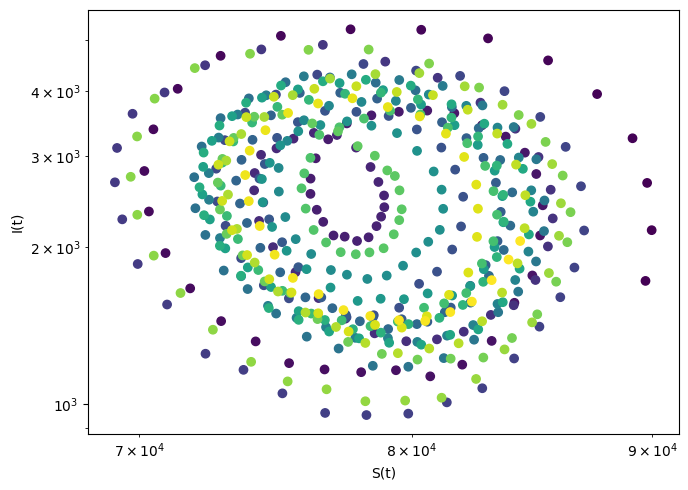

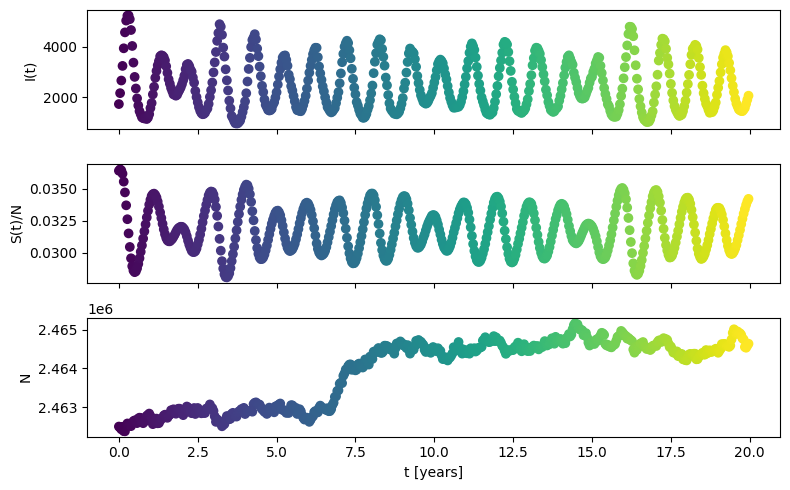

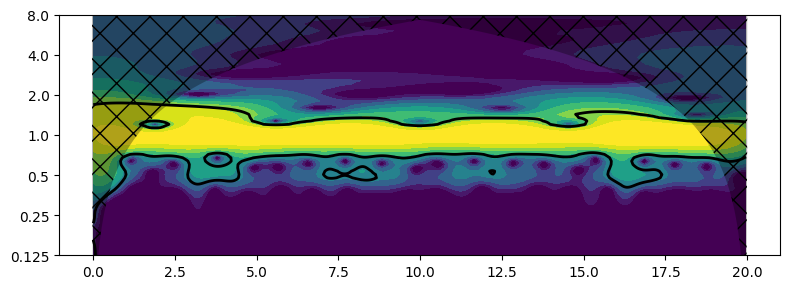

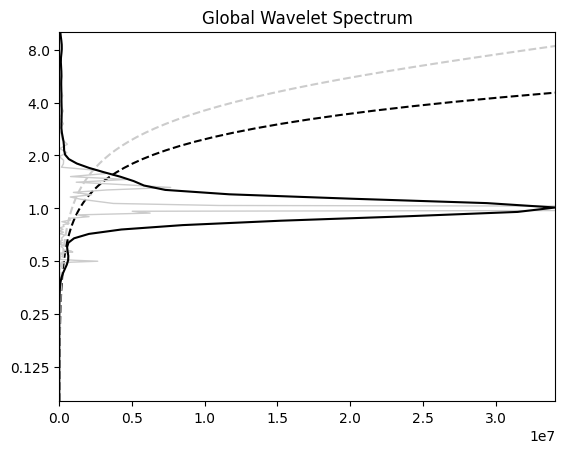

In [39]:

from plotting import plot_timeseries, plot_wavelet_spectrum
plot_timeseries(model.nodes.timeseries[0, :, :])
plot_wavelet_spectrum(model.nodes.timeseries[0, :, 1])

import matplotlib.pyplot as plt
plt.show()


# EW Spatial Sim

DEBUG:timer.simulate:start


                Long     Lat  population  births
London        -0.105  51.517   2462500.0   44851
Birmingham    -1.860  52.485    993310.0   22644
Liverpool     -2.942  53.417    666230.0   15623
Manchester    -2.250  53.482    614760.0   12332
Sheffield     -1.467  53.383    474180.0   10111
Leeds         -1.538  53.805    451100.0    8601
Bristol       -2.570  51.477    405530.0    7807
Newcastle     -1.602  54.973    262920.0    5422
Nottingham    -1.160  52.967    262310.0    5733
Bradford      -1.750  53.788    261890.0    4678
Leicester     -1.137  52.635    257450.0    5280
Stoke         -1.465  52.403    250500.0    5445
Hull          -0.340  53.750    229640.0    5031
Coventry      -1.508  52.403    222210.0    5584
Cardiff       -3.175  51.482    215130.0    4514
Croydon       -0.083  51.363    190130.0    3582
Harrow        -0.348  51.583    185090.0    3472
Sunderland    -1.385  54.910    161450.0    3656
Portsmouth    -1.072  50.808    155860.0    3755
Salford       -2.295

DEBUG:timer.simulate:cost 461 ms
/Users/christopherlorton/projects/laser/.venv/lib/python3.9/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


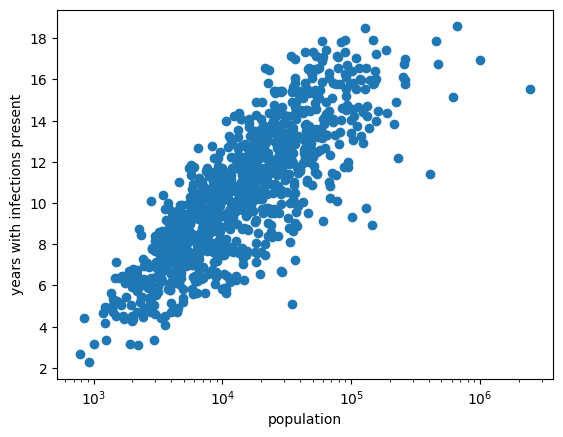

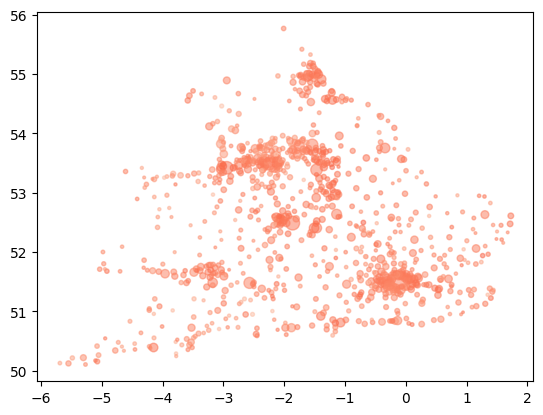

In [48]:
from idmlaser.utils import PropertySet

import numpy as np
from timer import timer

from mixing import init_gravity_diffusion


def init_state(settlements_df, params):
    
    population_s = settlements_df.population.astype(int)
    births_s = settlements_df.births.astype(int)

    N = population_s
    S = births_s * 2
    I = (S / 26. / 2.).astype(int)

    state = np.array([S, I, N-S-I]).T

    params.biweek_avg_births = params.demog_scale * births_s / 26.
    params.biweek_death_prob = params.demog_scale * births_s / N / 26.

    params.mixing = init_gravity_diffusion(settlements_df, params.mixing_scale, params.distance_exponent)

    return state


def step_state(state, params, t):

        expected = params.beta * (1 + params.seasonality * np.cos(2*np.pi*t/26.)) * np.matmul(params.mixing, state[:, 1])
        prob = 1 - np.exp(-expected/state.sum(axis=1))
        dI = np.random.binomial(n=state[:, 0], p=prob)

        state[:, 2] += state[:, 1]
        state[:, 1] = 0

        births = np.random.poisson(lam=params.biweek_avg_births)
        deaths = np.random.binomial(n=state, p=np.tile(params.biweek_death_prob, (3, 1)).T)

        state[:, 0] += births
        state -= deaths

        state[:, 1] += dI
        state[:, 0] -= dI


@timer("simulate", unit="ms")
def simulate(init_state, params, n_steps):
    
    state_timeseries = np.zeros((n_steps, *init_state.shape), dtype=int)

    state = init_state

    for t in range(n_steps):
        state_timeseries[t, :, :] = state
        step_state(state, params, t)

    return state_timeseries


import logging
logging.basicConfig()
logging.getLogger('timer').setLevel(logging.DEBUG)

import matplotlib.pyplot as plt 

from settlements import parse_settlements
settlements_df = parse_settlements()

biweek_steps = 26 * 20
params = PropertySet(dict(beta=32, seasonality=0.15, demog_scale=1.0,
                mixing_scale=0.001, distance_exponent=1.5))
print(params)

n_settlements = None
init_state = init_state(settlements_df.iloc[:n_settlements, :], params)
states = simulate(init_state, params, n_steps=biweek_steps)

# --------

presence_tsteps = (states[:, :, 1] > 0).sum(axis=0)
plt.scatter(settlements_df.population[:n_settlements], presence_tsteps / 26.)
ax = plt.gca()
ax.set(xscale='log', xlabel='population', ylabel='years with infections present')

# --------

# test_ix = 800  # a smaller village to see some extinction + reintroduction dynamics
# print(settlements_df.iloc[test_ix])
# test_states = states[:, test_ix, :]  # (time, location, SIR)

# from plotting import plot_timeseries, plot_wavelet_spectrum
# plot_timeseries(test_states)
# plot_wavelet_spectrum(test_states[:, 1])  # infecteds

# --------

# TODO: Something like https://www.nature.com/articles/414716a#Sec4 and/or Xia et al. (2004)

# --------

import matplotlib.animation as animation
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

scat = ax.scatter(
    settlements_df.Long, 
    settlements_df.Lat, 
    s=0.1*np.sqrt(settlements_df.population), 
    c=states[0, :, 1] / states[0, :, :].sum(axis=-1), 
    cmap="Reds", norm=LogNorm(vmin=1e-4, vmax=0.01), alpha=0.5)

def animate(i):
        ax.set_title("{:.2f} years".format(i/26.))
        scat.set_array(states[i, :, 1] / states[i, :, :].sum(axis=-1))
        return scat,

ani = animation.FuncAnimation(fig, animate, frames=states.shape[0]-1, interval=50, blit=False)

# To save the animation using Pillow as a gif
# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# ani.save('figures/ew_spatial_animation.gif', writer=writer)

plt.show()


# LASER Spatial Sim

DEBUG:timer.simulate:start


                Long     Lat  population  births
London        -0.105  51.517   2462500.0   44851
Birmingham    -1.860  52.485    993310.0   22644
Liverpool     -2.942  53.417    666230.0   15623
Manchester    -2.250  53.482    614760.0   12332
Sheffield     -1.467  53.383    474180.0   10111
Leeds         -1.538  53.805    451100.0    8601
Bristol       -2.570  51.477    405530.0    7807
Newcastle     -1.602  54.973    262920.0    5422
Nottingham    -1.160  52.967    262310.0    5733
Bradford      -1.750  53.788    261890.0    4678
Leicester     -1.137  52.635    257450.0    5280
Stoke         -1.465  52.403    250500.0    5445
Hull          -0.340  53.750    229640.0    5031
Coventry      -1.508  52.403    222210.0    5584
Cardiff       -3.175  51.482    215130.0    4514
Croydon       -0.083  51.363    190130.0    3582
Harrow        -0.348  51.583    185090.0    3472
Sunderland    -1.385  54.910    161450.0    3656
Portsmouth    -1.072  50.808    155860.0    3755
Salford       -2.295

DEBUG:timer.simulate:cost 336 ms


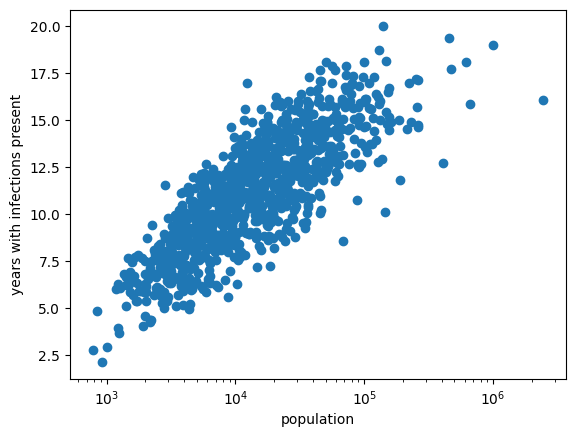

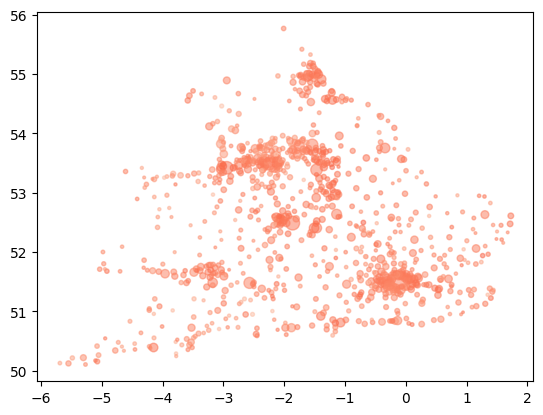

In [66]:
import numpy as np
from timer import timer
from mixing import init_gravity_diffusion

import logging
logging.basicConfig()
logging.getLogger("timer").setLevel(logging.DEBUG)

import matplotlib.pyplot as plt

from settlements import parse_settlements
settlements_df = parse_settlements()

biweek_steps = 26 * 20
class Model:
    pass

model = Model()
from idmlaser.utils import PropertySet
model.params = PropertySet({"beta": 32, "seasonality": 0.15, "demog_scale": 1.0,
                        "mixing_scale": 0.001, "distance_exponent": 1.5})

def init_state(model, settlements_df):

    population_s = settlements_df.population.astype(int)
    births_s = settlements_df.births.astype(int)

    N = population_s
    S = births_s * 2
    I = (S / 26.0 / 2.0).astype(int)

    model.nodes.states[:, :] = np.array([S, I, N-S-I], np.uint32).T

    params = model.params
    params.biweek_avg_births = params.demog_scale * births_s / 26.0
    params.biweek_death_prob = params.demog_scale * births_s / N / 26.0

    params.mixing = init_gravity_diffusion(settlements_df, params.mixing_scale, params.distance_exponent)

    return

model.nodes = Population(len(settlements_df))
model.nodes.add_vector_property("states", 3)

n_settlements = model.nodes.capacity
initial_state = init_state(model, settlements_df.iloc[:n_settlements, :])

def step_state(model, t):

    params = model.params
    state = model.nodes.states

    expected = params.beta * (1 + params.seasonality * np.cos(2*np.pi*t/26.)) * np.matmul(params.mixing, state[:, 1])
    prob = 1 - np.exp(-expected/state.sum(axis=1))
    dI = np.random.binomial(n=state[:, 0], p=prob).astype(state.dtype)

    state[:, 2] += state[:, 1]
    state[:, 1] = 0

    births = np.random.poisson(lam=params.biweek_avg_births).astype(state.dtype)
    deaths = np.random.binomial(n=state, p=np.tile(params.biweek_death_prob, (3, 1)).T).astype(state.dtype)

    state[:, 0] += births
    state -= deaths

    state[:, 1] += dI
    state[:, 0] -= dI

    return

@timer("simulate", unit="ms")
def simulate(model, n_steps):

    model.nodes.add_vector_property("timeseries", (n_steps, 3))

    for t in range(n_steps):
        for p in model.phases:
            p(model, t)

    return

def report(model, t):
    model.nodes.timeseries[:, t, :] = model.nodes.states[:, :]
    return

model.phases = [report, step_state]

simulate(model, n_steps=biweek_steps)

timeseries = model.nodes.timeseries
presence_tsteps = (timeseries[:, :, 1] > 0).sum(axis=1)
plt.scatter(settlements_df.population[:n_settlements], presence_tsteps / 26.)
ax = plt.gca()
ax.set(xscale='log', xlabel='population', ylabel='years with infections present')


import matplotlib.animation as animation
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

scat = ax.scatter(
    settlements_df.Long, 
    settlements_df.Lat, 
    s=0.1*np.sqrt(settlements_df.population), 
    c=timeseries[:, 0, 1] / timeseries[:, 0, :].sum(axis=-1), 
    cmap="Reds", norm=LogNorm(vmin=1e-4, vmax=0.01), alpha=0.5)

# def animate(i):
#         ax.set_title("{:.2f} years".format(i/26.))
#         scat.set_array(timeseries[:, i, 1] / timeseries[:, i, :].sum(axis=-1))
#         return scat,

# ani = animation.FuncAnimation(fig, animate, frames=timeseries.shape[1]-1, interval=50, blit=False)

plt.show()
